In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import json

import torch
import transformers as ppb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Loading Transcript

In [2]:
all_trans = list()
path_to_jsonfiles = "../input/harpervalleydataset-transcript-only/HarperValleyDataset_transcript/HarperValley_transcript/"
for file in os.listdir(path_to_jsonfiles):
    filename = "%s%s" % (path_to_jsonfiles, file)
    with open(filename, 'r') as fi:
        js_text = json.load(fi)
        h_trans = [item["speaker_role"] + " " + item["human_transcript"] for item in js_text]
        str_trans = ' '.join(str(item) for item in h_trans)
        all_trans.append(str_trans)

In [3]:
print(type(all_trans))
print(len(all_trans))
print(all_trans[:5])

<class 'list'>
1000
["agent hello this is harper valley national bank my name is jennifer how can i help you today agent [noise] caller hi my name is james williams caller i would like to schedule an appointment agent sure i can help you with that james uh what day would you like for your appointment caller saturday agent okay agent and what time would you like for your appointment caller one fifteen p m agent [noise] agent [noise] agent alright uh james i'm scheduling your appointment for saturday at one fifteen p m uh is there anything else that i can help you with today caller no thank you that'll be everything today agent oh you're welcome thank you for calling and have a great day caller you too agent bye bye caller [noise]", 'agent hello this is harper valley national bank my name is david agent how can i help you today caller hi my name is john rodriguez and i would like to reset my password agent what is your phone number caller my phone number is zero two one caller eight nine

In [4]:
df_x = pd.DataFrame(all_trans, columns = ["transcript"])
df_x.tail()

,transcript
995,agent hello this is harper valley national ban...
996,agent hello this is harper valley national ban...
997,agent hello agent this is harper valley nation...
998,agent hello this is agent hello this is harper...
999,agent [noise] agent hello this is harper valle...


# Loading Labels

In [5]:
### Get the task list from metadata

all_labels = list()
path_to_matadat = "../input/harpervalleydataset-transcript-only/HarperValleyDataset_metadata/metadata/"
for file in os.listdir(path_to_matadat):
    filename = "%s%s" % (path_to_matadat, file)
    with open(filename, 'r') as fi:
        js_text = json.load(fi)
        task = js_text["tasks"][0]["task_type"]
        all_labels.append(task)

In [6]:
y_list = np.array(all_labels)
print(type(y_list))
print(y_list.shape)
y_list_2d = np.reshape(y_list, (-1, 1))
print(y_list_2d.shape)
print("y_list\n", y_list[0:6], "\n y_list_2d\n", y_list_2d[0:6])

<class 'numpy.ndarray'>
(1000,)
(1000, 1)
y_list
 ['schedule appointment' 'reset password' 'get branch hours'
 'schedule appointment' 'schedule appointment' 'check balance'] 
 y_list_2d
 [['schedule appointment']
 ['reset password']
 ['get branch hours']
 ['schedule appointment']
 ['schedule appointment']
 ['check balance']]


In [7]:
df_y = pd.DataFrame(all_labels, columns = ["tasks"])
df_y.tail()

,tasks
995,check balance
996,order checks
997,order checks
998,order checks
999,check balance


In [8]:
# print(len(all_labels))
i = 1000-1
print(all_labels[i])
print(all_trans[i])

check balance
agent [noise] agent hello this is harper valley national bank my name is mary how can i help you today caller [noise] hi my name is linda smith i need to check my account balance agent alright i can help you with that and and which account would you like to check caller my savings account agent alright agent your savings account balance is eighty nine dollars is there anything else i can help you with today caller no that'll be all thank you agent uh huh thank <unk> thank you for calling and you have a great day


In [9]:
filename1 = "../input/harpervalleydataset-transcript-only/HarperValleyDataset_metadata/metadata/0002f70f7386445b.json"
with open(filename1, 'r') as fi:
    js_text = json.load(fi)
    task = js_text["tasks"][0]["task_type"]
#     all_labels.append(h_trans)

In [10]:
print(task)

replace card


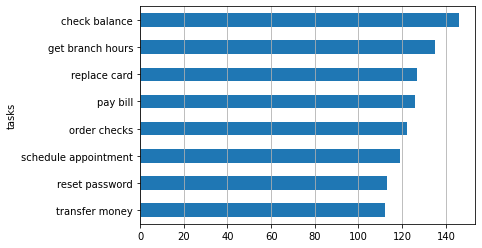

In [11]:
x = "tasks"
fig, ax = plt.subplots()
# fig.suptitle(x, fontsize=12)
df_y[x].reset_index().groupby(x).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.savefig("task_distribution.png", bbox_inches='tight')
plt.show()

## Concateneting X and y

In [12]:
# df = df_x.merge(df_y, left_on="transcript", right_on="tasks")
df = pd.concat([df_x, df_y], axis=1)
df.tail()
# df.size

,transcript,tasks
995,agent hello this is harper valley national ban...,check balance
996,agent hello this is harper valley national ban...,order checks
997,agent hello agent this is harper valley nation...,order checks
998,agent hello this is agent hello this is harper...,order checks
999,agent [noise] agent hello this is harper valle...,check balance


# Processing Data

In [13]:
max_len = len(df["transcript"][15])
print(max_len)

627


# Model
## DistilBert

In [14]:
model_class = ppb.DistilBertModel
tokenizer_class = ppb.DistilBertTokenizer
pretrained_weights = "distilbert-base-uncased"

# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Tokenization

In [15]:
tokenized_X = df["transcript"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
# tokenized_y = df["tasks"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [16]:
print(type(tokenized_X))
print(tokenized_X.size)
tokenized_X.head()

<class 'pandas.core.series.Series'>
1000


0    [101, 4005, 7592, 2023, 2003, 8500, 3028, 2120...
1    [101, 4005, 7592, 2023, 2003, 8500, 3028, 2120...
2    [101, 4005, 7592, 2023, 2003, 8500, 3028, 2120...
3    [101, 4005, 7592, 2023, 2003, 8500, 3028, 2120...
4    [101, 4005, 7592, 2023, 2003, 8500, 3028, 2120...
Name: transcript, dtype: object

## Padding

### Transcripts

In [17]:
max_len_X = 0
for i in tokenized_X.values:
    if len(i) > max_len_X:
        max_len_X = len(i)
        
padded_X = np.array([i + [0]*(max_len_X-len(i)) for i in tokenized_X.values])

In [18]:
print(type(padded_X))
print(padded_X[:5])
print(padded_X.shape)

<class 'numpy.ndarray'>
[[ 101 4005 7592 ...    0    0    0]
 [ 101 4005 7592 ...    0    0    0]
 [ 101 4005 7592 ...    0    0    0]
 [ 101 4005 7592 ...    0    0    0]
 [ 101 4005 7592 ...    0    0    0]]
(1000, 430)


### Slicing

In [19]:
jk_1 = padded_X[:, 0:1]
print(jk_1.shape)
jl_1 = padded_X[:, 15:55]
print(jl_1.shape)

(1000, 1)
(1000, 40)


In [20]:
sliced_X = np.concatenate((padded_X[:,0:1], padded_X[:, 15:55]), axis=1)

print(type(sliced_X))
print(sliced_X.shape)
print(sliced_X[:5])

<class 'numpy.ndarray'>
(1000, 41)
[[  101  1045  2393  2017  2651  4005  1031  5005  1033 20587  7632  2026
   2171  2003  2508  3766 20587  1045  2052  2066  2000  6134  2019  6098
   4005  2469  1045  2064  2393  2017  2007  2008  2508  7910  2054  2154
   2052  2017  2066  2005  2115]
 [  101  2064  1045  2393  2017  2651 20587  7632  2026  2171  2003  2198
   9172  1998  1045  2052  2066  2000 25141  2026 20786  4005  2054  2003
   2115  3042  2193 20587  2026  3042  2193  2003  5717  2048  2028 20587
   2809  3157  2274 20587  2093]
 [  101  1045  2393  2017  2651 20587  7632  2026  2171  2003  3870  3557
  20587  2054  2024  1996  2334  3589  2847  4005  1996  3589  2847  2024
   3157  4228  1037  1049  2127  2274  1052  1049  4005  2003  2045  2505
   2842  1045  2064  2393  2017]
 [  101  1045  2393  2017  2651 20587  7632  2026  2171  2003  2984  9172
  20587  1045  2052  2066  2000  6134  2019  6098  4005  2821  2469  1045
   2064  2393  2017  2007  2008  7910  2029  2154  2

## Masking

In [21]:
attention_mask_X = np.where(sliced_X != 0, 1, 0)
print(attention_mask_X.shape)
print(attention_mask_X[:5])

(1000, 41)
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1]]


# Processing with DistilBERT

In [22]:
X_ids = torch.tensor(np.array(sliced_X))
attention_mask_X_tensor = torch.tensor(attention_mask_X)

with torch.no_grad():
    last_hidden_states = model(X_ids, attention_mask=attention_mask_X_tensor)

In [23]:
print(type(last_hidden_states))
print(np.size(last_hidden_states))

<class 'transformers.modeling_outputs.BaseModelOutput'>
1


In [24]:
features = last_hidden_states[0][:,0,:].numpy()
print(type(features))
print(features.shape)

<class 'numpy.ndarray'>
(1000, 768)


# Logistic Regression

### Test set (Train test split)

In [25]:
train_features, test_features, train_labels, test_labels = train_test_split(features, y_list, test_size=0.25)
print("type:", type(train_features), type(train_labels))
print("train_feature_size", train_features.shape)
print("test_feature_size", test_features.shape)
print("train_labels_size", train_labels.shape)
print("test_labels_size", test_labels.shape)

type: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
train_feature_size (750, 768)
test_feature_size (250, 768)
train_labels_size (750,)
test_labels_size (250,)


## Logistic regression

In [26]:
lr_clf = LogisticRegression(multi_class="multinomial", max_iter=1000)
lr_clf.fit(train_features, train_labels)

LogisticRegression(max_iter=1000, multi_class='multinomial')

## Evaluation

In [27]:
lr_clf.score(test_features, test_labels)

0.964

In [28]:
preds = lr_clf.predict(test_features)

In [29]:
print(type(preds))

<class 'numpy.ndarray'>


In [30]:
pd.DataFrame(preds).to_csv("preds.csv")

In [31]:
pd.DataFrame(test_labels).to_csv("Actuals.csv")

### Confusion Matrix and F1 Score

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [33]:
f1_scr_weighted = f1_score(test_labels, preds, average='weighted')
print(f1_scr_weighted)
f1_scr_micro = f1_score(test_labels, preds, average='micro')
print(f1_scr_micro)
f1_scr_macro = f1_score(test_labels, preds, average='macro')
print(f1_scr_macro)

0.9641106472743799
0.964
0.964400179183124


In [34]:
df['tasks'].value_counts()

check balance           146
get branch hours        135
replace card            127
pay bill                126
order checks            122
schedule appointment    119
reset password          113
transfer money          112
Name: tasks, dtype: int64

In [35]:
cm = confusion_matrix(test_labels, preds)
cm_df = pd.DataFrame(cm, 
                    index = ['check balance', 'get branch hours', 'replace card', 'pay bill', 'order checks', 'schedule appointment', 'reset password', 'transfer money'],
                    columns = ['check balance', 'get branch hours', 'replace card', 'pay bill', 'order checks', 'schedule appointment', 'reset password', 'transfer money'])

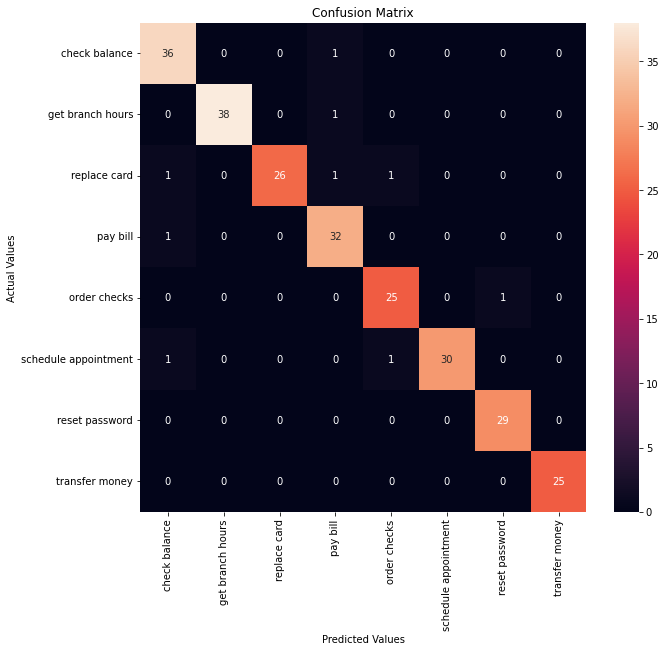

In [36]:
plt.figure(figsize=(10,9))
sns.heatmap(cm_df, annot=True)
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.savefig("Confusion_matrix")
plt.show()